In [1]:
from mems_model import mems_model
from ceo.wfsc_lib.gmt_pupil_model import gmt_pupil_model

/home/ubuntu/CEO/python/ceo/zemax


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# MEMS2k model
Initial version: 03/17/2025

Created by: fquiros

The model is built upon a single influence function extracted from a full real measured dataset from MagAO-X MEMS2k DM (courtesy of J. Males). A full set of influence functions is simply built by replicating such influence function (with linear interpolation) over the DM grid.

*Note 1:* The pitch of the real MEMS2k was also estimated from the real data, and stored in the "reference influence function file". This file is pass on to **mems_model** to build the model.

*Note 2:* The valid 2040 actuators are defined in the "actuator mask" passed on to the **mems_model**. Our first assumption is that *all* actuators are operational. This definition should be revisited to take into account actuator defects (e.g. non-working, coupled, ...)

The actuators pitch in meters is a free parameter of the **mems_model** class.

Update: 03/18/2025
- Added grid rotation. 
- Included GMT mask over grid and over influence functions.

Update: 04/24/2025
- New information on bad actuators as reported from BMC -> new optimal clocking.

In [3]:
#-- Data files containing Influence Function and actuator mask.
ref_ifunc_fname = './data/mems2k/MagAO-X_MEMS2k_ReferenceIF.npz'
act_mask_fname = './data/mems2k/BMC_2k_act_mask.npz'
#bad_acts_idx = [7, 384, 1664, 1737, 288, 289]  # previous information (2017)
bad_acts_idx = [359, 383]
hump =  [647, 648, 696, 697]

#-- Specify desired actuator pitch in meters, and grid rotation in degrees.
Dtel = 25.4 #m
act_pitch_m = Dtel / 48
grid_rot_deg = -2.5#-12.30 # Angle that places the Bumps in-between segments.

#-- Initialize the model using the mems_model class
mems2k = mems_model(ref_ifunc_fname, act_mask_fname, act_pitch_m=act_pitch_m, grid_rot_deg=grid_rot_deg)

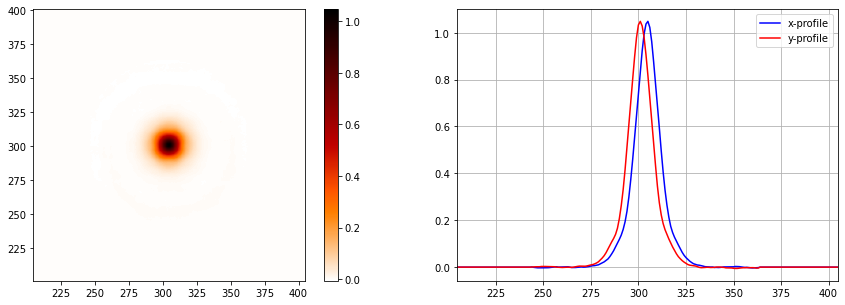

In [4]:
#-- Show reference influence function
ref_ifunc    = mems2k._mems_model__ref_ifunc
ref_ifunc_sz = mems2k._mems_model__ref_ifunc.shape
ref_ifunc_maxloc = mems2k._mems_model__ref_ifunc_row_center, mems2k._mems_model__ref_ifunc_col_center

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches((15,5))
im1 = ax1.imshow(ref_ifunc, cmap='gist_heat_r', origin='lower')
clb1 = fig.colorbar(im1, ax=ax1)
ax1.set_xlim([ref_ifunc_maxloc[1]-100, ref_ifunc_maxloc[1]+100]);
ax1.set_ylim([ref_ifunc_maxloc[0]-100, ref_ifunc_maxloc[0]+100]);

ax2.plot(ref_ifunc[round(ref_ifunc_maxloc[0]),:], color='b',label='x-profile')
ax2.plot(ref_ifunc[:,round(ref_ifunc_maxloc[1])], color='r',label='y-profile')

ax2.grid()
ax2.legend()
ax2.set_xlim([ref_ifunc_maxloc[1]-100, ref_ifunc_maxloc[1]+100]);
#ax2.set_ylim([-0.006,0.1])

## DM grid
Show the DM grid and the GMT pupil overimposed.

In [5]:
#-- pupil over DM grid
truss_shadows = False
GMTpup_model = gmt_pupil_model(mems2k._grid_n_acts, act_pitch_m, truss_shadows=truss_shadows)
Dext = act_pitch_m * (mems2k._grid_n_acts-1)

Total number of actuators: 2040


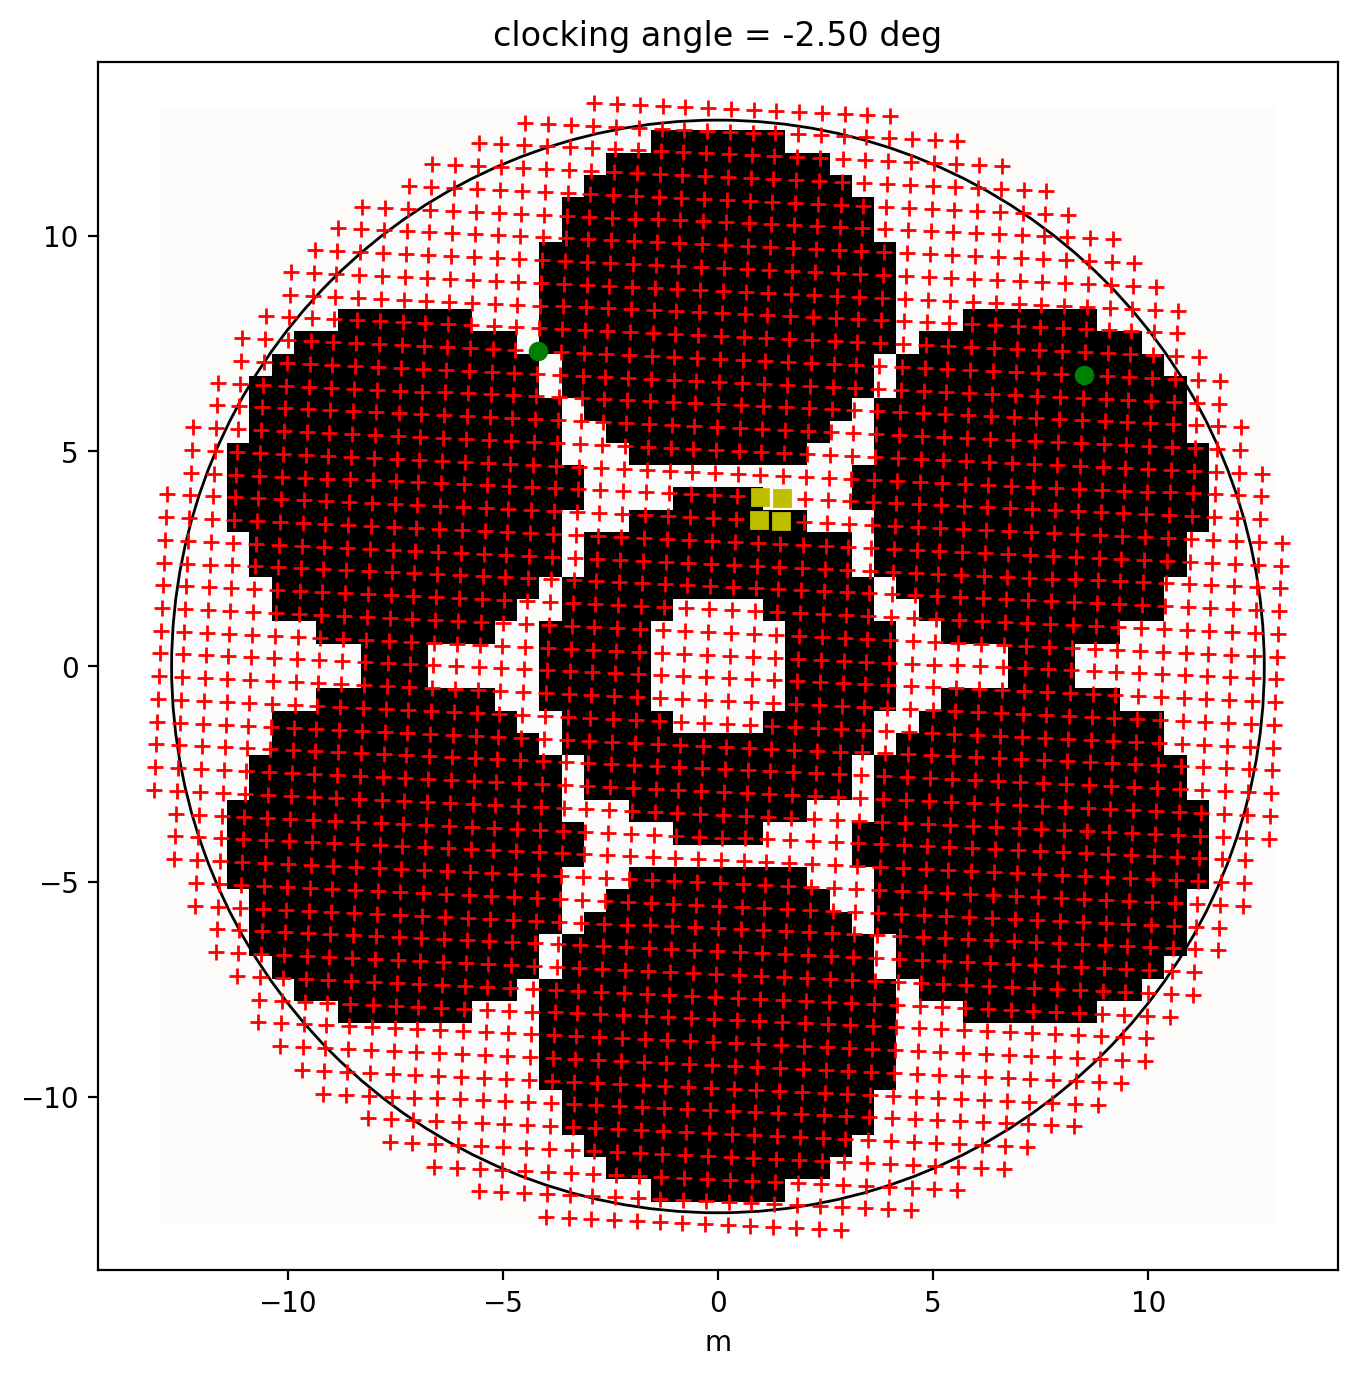

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches((8,8))
fig.dpi = 200
ax.imshow(GMTpup_model, interpolation='none', origin='lower', aspect='equal', extent=[-Dext/2, Dext/2, -Dext/2, Dext/2], cmap=plt.cm.gist_earth_r)
ax.plot(mems2k._act_col_meters, mems2k._act_row_meters, 'r+')
ax.plot(mems2k._act_col_meters[bad_acts_idx], mems2k._act_row_meters[bad_acts_idx], 'go', label='non-responsive')
ax.plot(mems2k._act_col_meters[hump], mems2k._act_row_meters[hump], 'ys', label='hump')
ax.axis('equal')
ax.set_title('clocking angle = %0.2f deg'%grid_rot_deg)
ax.set_xlabel('m')
#ax.grid()

circ = Circle((0,0), Dtel/2, fill=False, color='k')
ax.add_artist(circ)

print('Total number of actuators: %d'%mems2k.n_acts)

## Generate IF cube
Compute all influence functions over the defined actuator grid, and store them as a data cube. The sampling of the arrays in the data cube is a free parameter. Influence functions will be interpolated in the defined grid respecting the original actuator pitch.

In [7]:
array_size_m = 25.5  # [m] Diameter of simulated square (slightly larger than GMT diameter) 
array_size_pix = 460 # numbers of pixels across the data array
array_pixscale = array_size_m / (array_size_pix-1)

In [8]:
mems2k.compute_if_cube(array_size_pix, array_size_m)

Completed creation of influence function cube of size 460 x 460 x 2040.


In [9]:
#--- GMT pupil mask
truss_shadows = True
GMTmask = gmt_pupil_model(array_size_pix, array_pixscale, truss_shadows=truss_shadows)

## Show some examples of actuator patterns

**Example 1.** Show every 13th influence function in the cube.

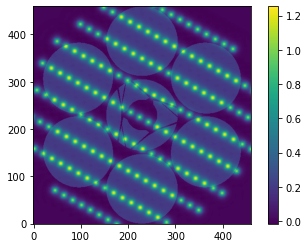

In [10]:
gridact_idx_test = np.arange(0, mems2k._grid_n_acts**2, 13)
act_idx_test = mems2k.gridact_to_act(gridact_idx_test)
plt.imshow( 0.2*GMTmask + np.sum(mems2k.IFcube[:,:,act_idx_test], axis=2), 
           origin='lower')#, cmap=plt.cm.gist_earth_r)
plt.colorbar()

**Example 2.** Show the famous *dagger* pattern used on HCAT.

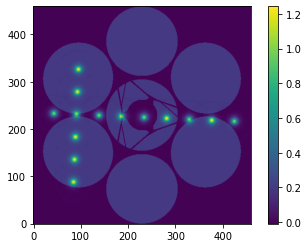

In [11]:
dagger_ongrid = [ 760, 1010, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295, 1510, 1760, 2010]
dagger = mems2k.gridact_to_act(dagger_ongrid)

plt.imshow( 0.2*GMTmask + np.sum(mems2k.IFcube[:,:,dagger], axis=2), origin='lower')
plt.colorbar()

**Example 3.** Location of bad actuators

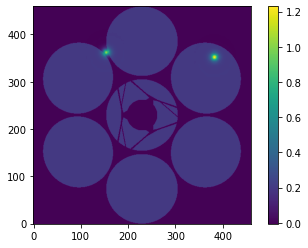

In [12]:
plt.imshow( 0.2*GMTmask + np.sum(mems2k.IFcube[:,:,bad_acts_idx], axis=2), origin='lower')
plt.colorbar()

Save influence functions to a dedicated file.